## 5. Deep Learning

### 5.1 Imports and Support Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models

import cv2, os, shutil
from torchvision import transforms
from pathlib import Path
from tqdm import tqdm
import subprocess
from PIL import Image
import matplotlib.colors as mcolors

In [1]:
def arrange_images_on_grid(images, grid_size, gap=0, background_value=0, cmap_name='viridis', 
                          vmin=None, vmax=None, border_width=0, border_color='#FFFFFF'):
    """
    Arrange a list of grayscale images on a grid into a larger image with optional borders.
    
    Parameters:
    - images: list of numpy arrays, each representing a grayscale image.
    - grid_size: tuple (rows, cols), specifying the grid size.
    - gap: int, gap between images in pixels.
    - background_value: int, background pixel intensity value (0-255).
    - cmap_name: str, name of the colormap to use.
    - vmin: float, minimum value for colormap normalization (if None, uses image min).
    - vmax: float, maximum value for colormap normalization (if None, uses image max).
    - border_width: int, width of the border around each image in pixels.
    - border_color: str (hex color like '#FF0000') or tuple of 3 floats (R, G, B) in range [0, 1].
    
    Returns:
    - numpy array representing the larger image.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Convert hex color to RGB tuple if needed
    if isinstance(border_color, str):
        # Remove '#' if present
        hex_color = border_color.lstrip('#')
        # Convert hex to RGB values in [0, 1] range
        border_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))
    
    cmap = plt.get_cmap(cmap_name)
    rows, cols = grid_size
    
    # Determine the size of the individual images (assuming all are the same size)
    img_height, img_width = images[0].shape
    
    # Account for borders in the total size calculations
    total_img_height = img_height + 2 * border_width
    total_img_width = img_width + 2 * border_width
    
    # Determine the size of the final grid image
    grid_height = rows * total_img_height + (rows - 1) * gap
    grid_width = cols * total_img_width + (cols - 1) * gap
    
    # Create the final grid image with the background value
    grid_image = np.full((grid_height, grid_width, 3), background_value/255.0, dtype=np.float32)
    
    # Place each image in the grid with borders
    for idx, img in enumerate(images):
        if idx >= len(images):
            break
            
        # Normalize the image to [0, 1] based on vmin and vmax
        current_vmin = vmin if vmin is not None else img.min()
        current_vmax = vmax if vmax is not None else img.max()
        
        # Clip and normalize the image
        img_normalized = np.clip(img, current_vmin, current_vmax)
        img_normalized = (img_normalized - current_vmin) / (current_vmax - current_vmin) if current_vmax > current_vmin else np.zeros_like(img)
        
        # Apply colormap (cmap expects values in [0, 1])
        img_cmap = cmap(img_normalized)
        
        row = idx // cols
        col = idx % cols
        start_y = row * (total_img_height + gap)
        start_x = col * (total_img_width + gap)
        
        # Draw border if border_width > 0
        if border_width > 0:
            # Fill the entire area (including border) with border color
            grid_image[start_y:start_y + total_img_height, 
                      start_x:start_x + total_img_width, :] = border_color
            
            # Place the actual image inside the border
            inner_start_y = start_y + border_width
            inner_start_x = start_x + border_width
            grid_image[inner_start_y:inner_start_y + img_height, 
                      inner_start_x:inner_start_x + img_width, :] = img_cmap[:, :, :3]
        else:
            # No border - place image directly
            grid_image[start_y:start_y + img_height, 
                      start_x:start_x + img_width, :] = img_cmap[:, :, :3]
    
    return grid_image

### 5.1 First Layer Viz
Reproduces figure 5.8

In [6]:
alexnet = models.alexnet(weights = True)
alexnet.eval();

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
grid_size=(8,8)
alexnet_layer_up_to=1 

frame = cv2.imread('data/holding_alexnet_pattern.jpg')

video_crop=[420,0,1500,1080] #Process stills or video
tfms = transforms.Compose([transforms.Resize((224, 224)), #Resize to standard alexnet size
                                transforms.ToTensor(), #Convert to tensor
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], #Normalize using imagenet stats 
                                                     std=[0.229, 0.224, 0.225])]) 

In [ ]:
im_pil=Image.fromarray(frame[:,:,(2,1,0)])
im_tensor = tfms(im_pil.crop(video_crop))

In [ ]:
im_pil.crop(video_crop)

<Figure size 640x480 with 0 Axes>

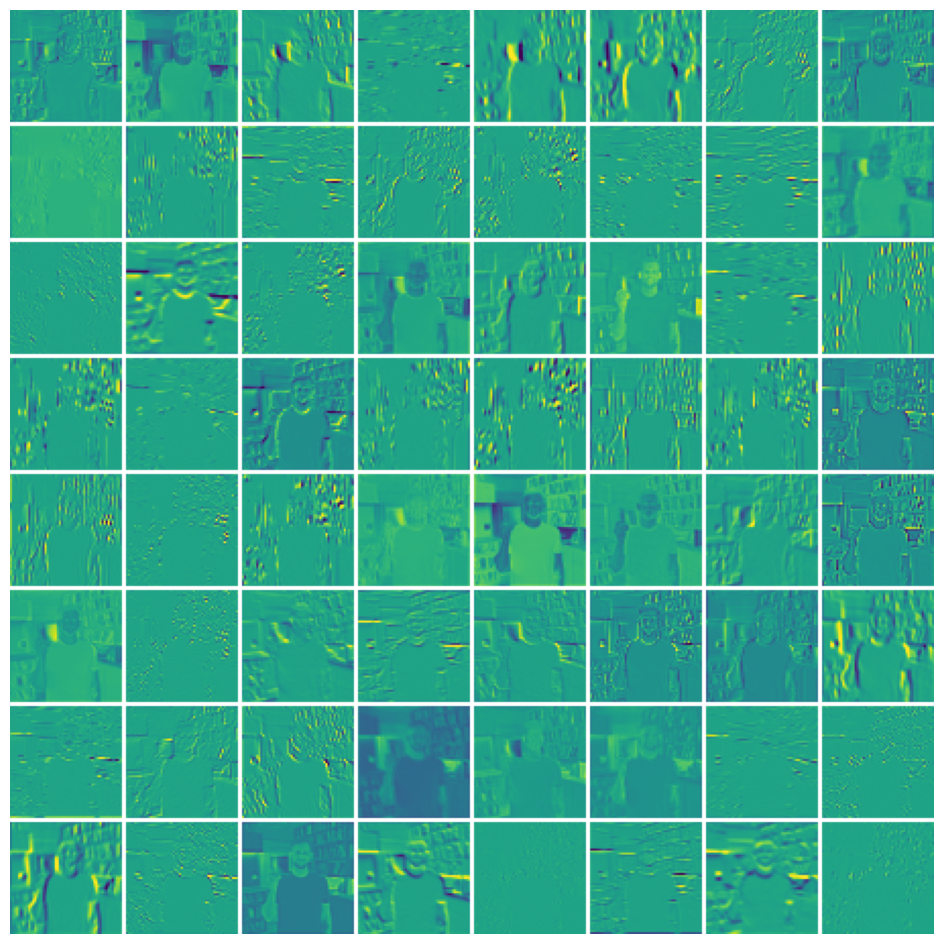

In [13]:
with torch.no_grad():
    activations = alexnet.features[:alexnet_layer_up_to](im_tensor[None]) #Pass image thr8ough first layer

plt.clf()
fig = plt.figure(0, (12, 12), facecolor='w') #
activations_numpy=activations.detach().numpy()[0]/activations.detach().numpy().max()
grid_image=arrange_images_on_grid(activations_numpy,
                   grid_size=grid_size, gap=2, background_value=255, cmap_name='viridis', vmin=-0.7, vmax=0.5,
                                 border_width=0, border_color='#948979')
plt.imshow(grid_image); plt.axis('off')
plt.axis('off');

### 5.3 Second Layer Viz
Figure 5.10

In [21]:
grid_size=(14,14)
alexnet_layer_up_to=5
frame = cv2.imread('data/holding_square_close.jpg')

In [22]:
im_pil=Image.fromarray(frame[:,:,(2,1,0)])
im_tensor = tfms(im_pil.crop(video_crop))

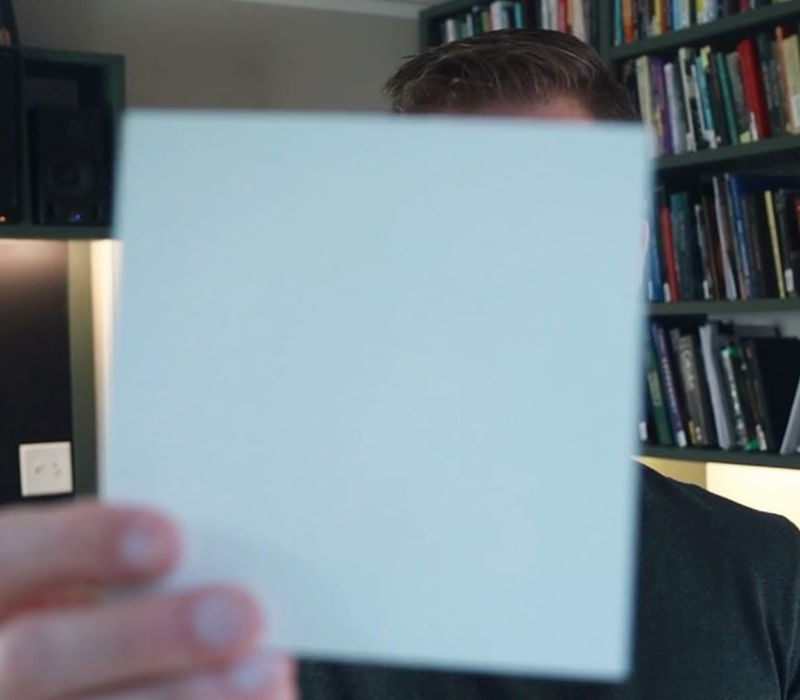

In [24]:
im_pil.crop(video_crop)

<Figure size 640x480 with 0 Axes>

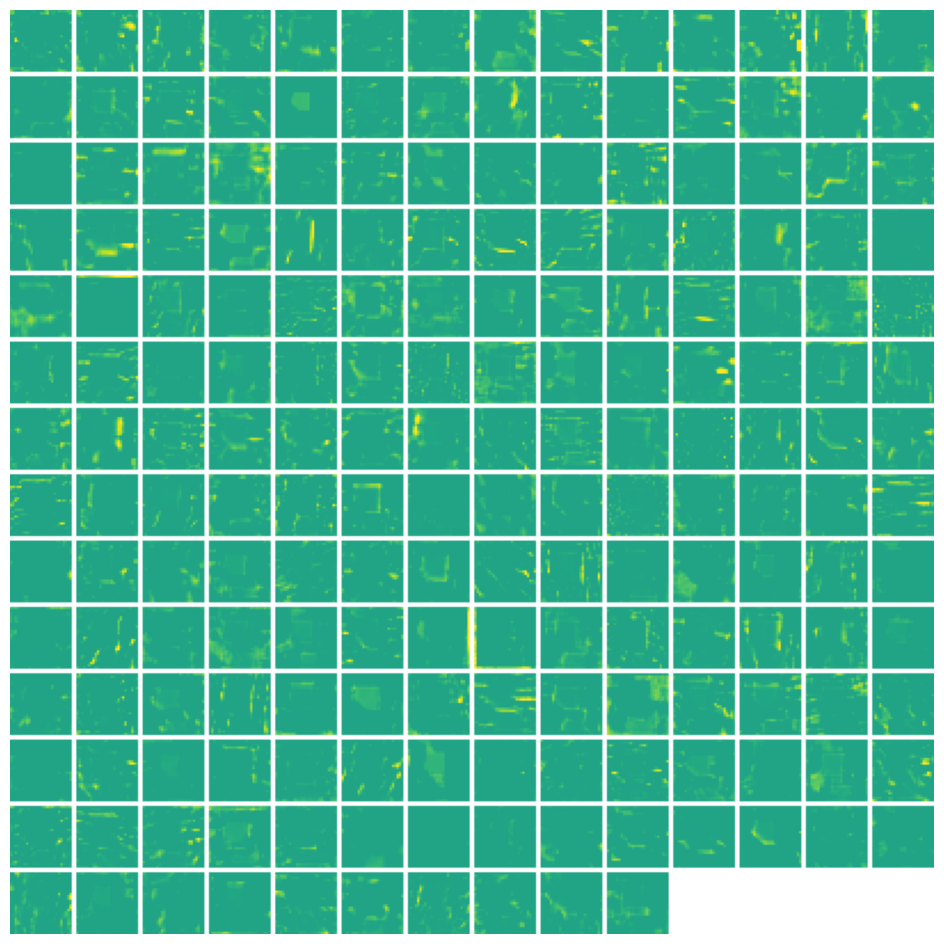

In [17]:
with torch.no_grad():
    activations = alexnet.features[:alexnet_layer_up_to](im_tensor[None]) #Pass image thr8ough first layer

plt.clf()
fig = plt.figure(0, (12, 12), facecolor='w') #
activations_numpy=activations.detach().numpy()[0]/activations.detach().numpy().max()
grid_image=arrange_images_on_grid(activations_numpy,
                   grid_size=grid_size, gap=2, background_value=255, cmap_name='viridis', vmin=-0.7, vmax=0.5,
                                 border_width=0, border_color='#948979')
plt.imshow(grid_image); plt.axis('off')
plt.axis('off');

### Fifth Layer Viz
Reproduces Figure 5.12

In [25]:
grid_size=(14,14)
alexnet_layer_up_to=5
frame = cv2.imread('data/face_close_up.jpg')

video_crop=[500,50,1300,750]
im_pil=Image.fromarray(frame[:,:,(2,1,0)])
im_tensor = tfms(im_pil.crop(video_crop))
im_numpy=np.array(im_pil.crop(video_crop).resize((128,128)))

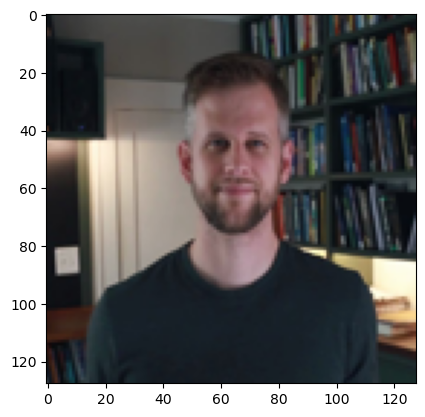

In [26]:
plt.imshow(im_numpy)

<Figure size 640x480 with 0 Axes>

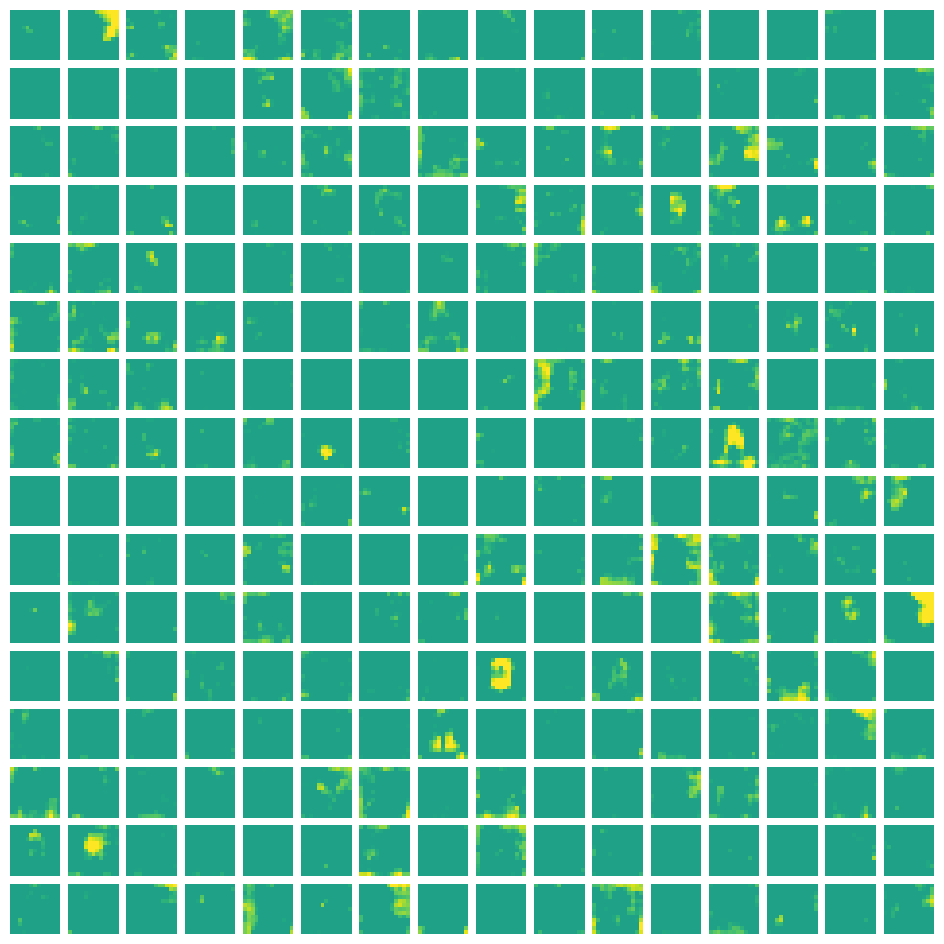

In [27]:
grid_size=(16,16)
alexnet_layer_up_to=12

with torch.no_grad():
    activations = alexnet.features[:alexnet_layer_up_to](im_tensor[None]) #Pass image thr8ough first layer

plt.clf()
fig = plt.figure(0, (12, 12), facecolor='w') #
activations_numpy=activations.detach().numpy()[0]/activations.detach().numpy().max()
grid_image=arrange_images_on_grid(activations_numpy,
                   grid_size=grid_size, gap=2, background_value=255, cmap_name='viridis', vmin=-0.6, vmax=0.45,
                                 border_width=0, border_color='#948979')
plt.imshow(grid_image); plt.axis('off')
plt.axis('off');